In [1]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# %matplotlib ipympl

Define the parameters and geometry for the simulation.

In [2]:
# Define parameters
X = 5
Y = 6
Z = 4
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [2, 2, 2]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [2, 3, 2]

Calculate old slow approach for comparison.

In [3]:
start = datetime.now()
# init object
radi = sp.radiosity.Radiosity(
    walls, patch_size, max_order_k, ir_length_s,
    speed_of_sound=speed_of_sound, sampling_rate=sampling_rate)

# run simulation
radi.run(source)

# gather energy at receiver
receiver = sp.geometry.Receiver(receiver_pos, [0, 1, 0], [0, 0, 1])
ir_slow = radi.energy_at_receiver(receiver, ignore_direct=True)
reverberation_slow = pf.Signal(ir_slow, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

/Users/anne/git/_pyfar/sparrowpy/sparrowpy/radiosity.py:59: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
100%|██████████| 150/150 [10:09<00:00,  4.07s/it]


Time elapsed: 0:10:16.684060


Calculate the analytical reference after Kuttruff.

In [4]:

S = (2*X*Y) + (2*X*Z) + (2*Y*Z)
A = S*absorption
alpha_dash = A/S
r_h = 1/4*np.sqrt(A/np.pi)
print(f'reverberation distance is {r_h}m')
V = X*Y*Z
RT = 24*np.log(10)/(speed_of_sound)*V/(-S*np.log(1-alpha_dash))
print(f'reverberation time is {RT}s')
E_reverb_analytical = 4/A
t = reverberation_slow.times
# Kuttruff Eq 4.7
w_0 = E_reverb_analytical/ V
t_0 = 0.03
# Kuttruff Eq 4.10
reverberation_analytic = w_0 * np.exp(+(
    speed_of_sound*S*np.log(1-alpha_dash)/(4*V))*(t-t_0))
reverberation_analytic = pf.Signal(
    reverberation_analytic, sampling_rate=sampling_rate)

reverberation distance is 0.5426201661567753m
reverberation time is 1.228475783983933s


Plot comparison

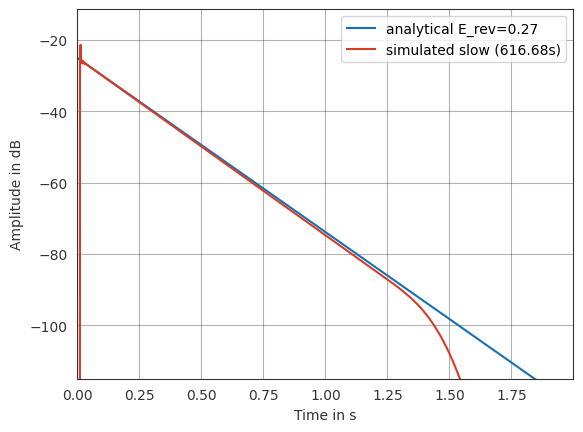

In [5]:
plt.figure()
pf.plot.time(
    reverberation_analytic, dB=True, log_prefix=10,
    label=f'analytical E_rev={E_reverb_analytical:0.2f}')
pf.plot.time(
    reverberation_slow, dB=True, log_prefix=10,
    label=f'simulated slow ({slow_time_s:0.2f}s)',
    linestyle='-')

plt.legend()
plt.show()

In [6]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

sparrowpy : 0.1.0
numpy     : 2.0.2
matplotlib: 3.10.0
pyfar     : 0.7.1

